# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
import os
from collections import Counter

## 1.1 Loading Data

In [2]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)
train_data = pd.read_csv("data.csv")
resource_data = pd.read_csv("resources.csv")

# feature Understanding

In [3]:
train_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [4]:
resource_data.columns

Index(['id', 'description', 'quantity', 'price'], dtype='object')

# Preprocessing catagorical

# Teacher Prefix  - 1

In [5]:
train_data.teacher_prefix.value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [6]:
# now first we found the Nan value and fill with "Mrs." because maximum number of the submition done by this prefix
train_data['teacher_prefix'].isnull().sum()

3

In [7]:
train_data['teacher_prefix'] = train_data['teacher_prefix'].fillna('Mrs')
train_data['teacher_prefix'] = train_data['teacher_prefix'].str.replace('.','') # Removing the "." from the last
train_data['teacher_prefix'] = train_data['teacher_prefix'].str.lower() # convert it into the lower case
train_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

# project_grade_category - 2

In [8]:
train_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [9]:
train_data['project_grade_category'].isnull().sum()

0

In [10]:
# replace (-) with (_)  and  replace (Grade) with ( )
train_data['project_grade_category'] = train_data['project_grade_category'].str.replace('-','_')
train_data['project_grade_category'] = train_data['project_grade_category'].str.replace('Grades',' ')

In [11]:
train_data['project_grade_category'].value_counts()

  PreK_2    44225
  3_5       37137
  6_8       16923
  9_12      10963
Name: project_grade_category, dtype: int64

# project_subject_subcategories - 3

In [12]:
train_data['project_subject_categories'].value_counts()

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

In [13]:
train_data['project_subject_categories'].isnull().sum()

0

In [14]:
train_data['project_subject_categories'] = train_data['project_subject_categories'].str.replace('&','_')
train_data['project_subject_categories'] = train_data['project_subject_categories'].str.replace(',','_')
train_data['project_subject_categories'] = train_data['project_subject_categories'].str.replace('The','')
train_data['project_subject_categories'] = train_data['project_subject_categories'].str.replace(' ','')
train_data['project_subject_categories'] = train_data['project_subject_categories'].str.lower()

In [15]:
train_data['project_subject_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

# project_subject_subcategories - 4

In [16]:
train_data['project_subject_subcategories'].value_counts()

Literacy                             9486
Literacy, Mathematics                8325
Literature & Writing, Mathematics    5923
Literacy, Literature & Writing       5571
Mathematics                          5379
                                     ... 
Community Service, Gym & Fitness        1
Parent Involvement, Team Sports         1
Gym & Fitness, Social Sciences          1
Community Service, Music                1
Economics, Foreign Languages            1
Name: project_subject_subcategories, Length: 401, dtype: int64

In [17]:
train_data['project_subject_subcategories'].isnull().sum()

0

In [18]:
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].str.replace('&','_')
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].str.replace(',','_')
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].str.replace('The','')
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].str.replace(' ','')
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].str.lower()

# school_state - 5

In [19]:
train_data['school_state'].value_counts()

CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

In [20]:
train_data['school_state'] = train_data['school_state'].str.lower()
train_data['school_state'].isnull().sum()

0

# Preprocessing text

# project_title - 1

In [21]:
train_data['project_title'].isnull().sum()

0

In [22]:
words_in_project_title = []
for word in train_data['project_title']:  # count the words in the title
    words = len(word.split())
    words_in_project_title.append(words)

In [23]:
## adding a words_in_project_title as a feature in the dataset
train_data['project_title_word'] = words_in_project_title  

# project_essay - 2

In [24]:
train_data['project_essay'] =  train_data['project_essay_1'].map(str)+train_data['project_essay_2'].map(str)+train_data['project_essay_3'].map(str)+train_data['project_essay_4'].map(str)

In [25]:
train_data.drop('project_essay_1', axis=1, inplace=True)
train_data.drop('project_essay_2', axis=1, inplace=True)
train_data.drop('project_essay_3', axis=1, inplace=True)
train_data.drop('project_essay_4', axis=1, inplace=True)

In [26]:
words_in_project_essay = []
for word in train_data['project_essay']:  # count the words in the essay
    words = len(word.split())
    words_in_project_essay.append(words)

In [27]:
train_data['project_essay_word'] = words_in_project_essay

In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [30]:
# https://gist.github.com/sebleier/554280
def preprocess_text(data):
    preprocessed_text = []
    for essay in tqdm(data):
        text = decontracted(essay)
        text = text.replace('\\r', ' ')
        text = text.replace('\\n', ' ')
        text = text.replace('\\"', ' ')
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        text = ' '.join(e for e in text.split() if e.lower() not in stopwords)
        preprocessed_text.append(text.lower().strip())
    return preprocessed_text

In [31]:
train_data['project_essay'] = preprocess_text(train_data['project_essay'].values)

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:04<00:00, 1685.20it/s]


In [32]:
train_data['project_essay'][5]

'moving 2nd grade 3rd grade beginning next school year takings current students move teach inclusion classroom includes students adhd sld well autistic students students work hard achieving goals no matter struggles may school teach houses great deal autistic students well ell students student love read work challenge also love move around work better able move room different areas rather usual set flexible seating options allow students different seating options instead sitting traditional desk chair able use flexible seating tools reduce stress anxiety tools beneficial students special needs also students proven fact students moving oxygen going brain means learning taking place flexible seating options allow students move traditional seat allows reduce stress classroom project significantly help students reduce stress anxiety standardized testing students 3rd grade required take state mandated test puts great deal stress students perform well test students able work throughout year 

In [33]:
train_data['project_title'] = preprocess_text(train_data['project_title'].values)

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 43718.14it/s]


In [34]:
train_data['project_title'][5]

'flexible seating mrs jarvis terrific third graders'

# project_resource_summary - 3

In [35]:
train_data['project_resource_summary'].isnull().sum()

0

In [36]:
words_in_project_resource_summary = []
for word in train_data['project_resource_summary']:  # count the words in the essay
    words = len(word.split())
    words_in_project_resource_summary.append(words)

In [37]:
## adding a words_in_project_title as a feature in the dataset
train_data['project_resource_summary_word'] = words_in_project_resource_summary

In [38]:
train_data['project_resource_summary'] = preprocess_text(train_data['project_resource_summary'].values)

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:06<00:00, 16859.30it/s]


In [39]:
train_data['project_resource_summary'][5]

'students need movement successful variety students different types needs flexible seating would assist not students special needs students'

In [40]:
train_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_title_word,project_essay,project_essay_word,project_resource_summary_word
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,PreK_2,literacy_language,esl_literacy,educational support english learners home,students need opportunities practice beginning...,0,0,7,students english learners working english seco...,272,13
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,students need projector help viewing education...,7,1,5,students arrive school eager learn polite gene...,221,11
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,students need shine guards athletic socks socc...,1,0,7,true champions not always ones win guts mia ha...,361,19
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,2016-10-06 21:16:17,PreK_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,students need engage reading math way inspire ...,4,1,2,work unique school filled esl english second l...,213,20
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,2016-07-11 01:10:09,PreK_2,math_science,mathematics,interactive math tools,students need hands practice mathematics fun p...,1,1,3,second grade classroom next year made around 2...,234,26


# Preprocessing Numerical

# Price

In [41]:
resource_data.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [42]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head()

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [43]:
# join two dataframes in python: 
train_data = pd.merge(train_data, price_data, on='id', how='left')

In [44]:
train_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_title_word,project_essay,project_essay_word,project_resource_summary_word,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,PreK_2,literacy_language,esl_literacy,educational support english learners home,students need opportunities practice beginning...,0,0,7,students english learners working english seco...,272,13,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,students need projector help viewing education...,7,1,5,students arrive school eager learn polite gene...,221,11,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,students need shine guards athletic socks socc...,1,0,7,true champions not always ones win guts mia ha...,361,19,516.85,22
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,2016-10-06 21:16:17,PreK_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,students need engage reading math way inspire ...,4,1,2,work unique school filled esl english second l...,213,20,232.90,4
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,2016-07-11 01:10:09,PreK_2,math_science,mathematics,interactive math tools,students need hands practice mathematics fun p...,1,1,3,second grade classroom next year made around 2...,234,26,67.98,4


In [45]:
from sklearn.preprocessing import StandardScaler            # applying the stand.scaler  to make data in same scale                          
scaler = StandardScaler()
scaler.fit(train_data['price'].values.reshape(-1, 1))
train_data['std_price']=scaler.transform(train_data['price'].values.reshape(-1, 1) )

In [46]:
# applying the MinMax scaler to make data in od range[0-1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data['price'].values.reshape(-1, 1))
train_data['nrm_price']=scaler.transform(train_data['price'].values.reshape(-1, 1))

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [47]:
train_data.isnull().sum()

Unnamed: 0                                      0
id                                              0
teacher_id                                      0
teacher_prefix                                  0
school_state                                    0
project_submitted_datetime                      0
project_grade_category                          0
project_subject_categories                      0
project_subject_subcategories                   0
project_title                                   0
project_resource_summary                        0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
project_title_word                              0
project_essay                                   0
project_essay_word                              0
project_resource_summary_word                   0
price                                           0
quantity                                        0
std_price                                       0


In [48]:
# 1. Split  dataset.
y = train_data['project_is_approved'].values
train_data.drop('project_is_approved',axis=1,inplace=True)
X = train_data

In [49]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [50]:
X_train.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_title_word,project_essay,project_essay_word,project_resource_summary_word,price,quantity,std_price,nrm_price
101063,138099,p163414,e0fb7c87a76a24c377dd4283125b135b,mrs,il,2016-06-22 23:50:16,PreK_2,literacy_language,literacy_literature_writing,author study books mary casanova,students need books specific author author study,2,6,students group energetic second graders elk gr...,182,12,170.76,15,-0.346559,0.017013
22157,106601,p150444,0eb47ae4a49788057ab89179366dfd2d,mrs,tx,2016-08-05 15:46:42,PreK_2,literacy_language_math_science,literature_writing_mathematics,circle time,students need teaching easel classroom not mob...,4,2,excited blessed continue teaching career aweso...,189,22,349.00,1,0.138452,0.034840
63988,75265,p124343,d796545b35ea17a1b9cf423eac224294,mrs,ok,2016-11-10 17:05:00,3_5,literacy_language_math_science,literature_writing_mathematics,learning technology,students need five tablets stay current today ...,0,3,students come school ready learn every day lov...,316,11,96.97,10,-0.547351,0.009633
87535,105469,p150845,427a97123efbbb426f7e384100c5623c,teacher,la,2016-09-02 17:42:31,PreK_2,appliedlearning_specialneeds,earlydevelopment_specialneeds,special education pssh need right tools,students need items help overcome exceptionali...,0,9,students variety special needs including devel...,410,19,542.85,23,0.665940,0.054228
98375,117847,p032048,acd985599bd44ad24a4fa0244cf79637,mrs,ky,2016-10-31 09:11:12,6_8,math_science_literacy_language,appliedsciences_literacy,digital accessories must,students need cases plug strips classroom tablets,4,5,not students resources home come ability level...,277,11,41.76,26,-0.697583,0.004111


In [51]:
print("Train:",X_train.shape, y_train.shape)
print("Cv:",X_cv.shape, y_cv.shape)
print("Test:",X_test.shape, y_test.shape)

Train: (49041, 20) (49041,)
Cv: (24155, 20) (24155,)
Test: (36052, 20) (36052,)


# Perform Bag of Words Vectorization of text data.

# eassy_bow

In [52]:
vectorizer_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow.fit(X_train['project_essay'].values) # fit has to happen only on train data

CountVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [53]:
essay_bow_Xtrain = vectorizer_bow.transform(X_train['project_essay'].values)
essay_bow_Xcv = vectorizer_bow.transform(X_cv['project_essay'].values)
essay_bow_Xtest = vectorizer_bow.transform(X_test['project_essay'].values)

In [54]:
print(essay_bow_Xtrain.shape)
print(essay_bow_Xcv.shape)
print(essay_bow_Xtest.shape)

(49041, 5000)
(24155, 5000)
(36052, 5000)


In [55]:
eassy_feature = vectorizer_bow.get_feature_names()

# title_bow

In [56]:
vectorizer_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow.fit(X_train['project_title'].values) # fit has to happen only on train data

CountVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [57]:
title_bow_Xtrain = vectorizer_bow.transform(X_train['project_title'].values)
title_bow_Xcv = vectorizer_bow.transform(X_cv['project_title'].values)
title_bow_Xtest = vectorizer_bow.transform(X_test['project_title'].values)

In [58]:
print(title_bow_Xtrain.shape)
print(title_bow_Xcv.shape)
print(title_bow_Xtest.shape)

(49041, 3442)
(24155, 3442)
(36052, 3442)


In [59]:
title_feature = vectorizer_bow.get_feature_names()

# project_resource_summary_bow

In [60]:
vectorizer_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow.fit(X_train['project_resource_summary'].values) # fit has to happen only on train data

CountVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [61]:
resource_summary_bow_Xtrain = vectorizer_bow.transform(X_train['project_resource_summary'].values)
resource_summary_bow_Xcv = vectorizer_bow.transform(X_cv['project_resource_summary'].values)
resource_summary_bow_Xtest = vectorizer_bow.transform(X_test['project_resource_summary'].values)

In [62]:
print(resource_summary_bow_Xtrain.shape)
print(resource_summary_bow_Xcv.shape)
print(resource_summary_bow_Xtest.shape)

(49041, 5000)
(24155, 5000)
(36052, 5000)


In [63]:
summary_feature = vectorizer_bow.get_feature_names()

# Perform tfidf vectorization of text data

# eassy_tfidf

In [64]:
vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf.fit(X_train['project_essay'].values) # fit has to happen only on train data

TfidfVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [65]:
essay_tfidf_Xtrain = vectorizer_tfidf.transform(X_train['project_essay'].values)
essay_tfidf_Xcv = vectorizer_tfidf.transform(X_cv['project_essay'].values)
essay_tfidf_Xtest = vectorizer_tfidf.transform(X_test['project_essay'].values)

In [66]:
print(essay_tfidf_Xtrain.shape)
print(essay_tfidf_Xcv.shape)
print(essay_tfidf_Xtest.shape)

(49041, 5000)
(24155, 5000)
(36052, 5000)


# title_tfidf

In [67]:
vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf.fit(X_train['project_title'].values) # fit has to happen only on train data

TfidfVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [68]:
title_tfidf_Xtrain = vectorizer_tfidf.transform(X_train['project_title'].values)
title_tfidf_Xcv = vectorizer_tfidf.transform(X_cv['project_title'].values)
title_tfidf_Xtest = vectorizer_tfidf.transform(X_test['project_title'].values)

In [69]:
print(title_tfidf_Xtrain.shape)
print(title_tfidf_Xcv.shape)
print(title_tfidf_Xtest.shape)

(49041, 3442)
(24155, 3442)
(36052, 3442)


# project_resource_summary_tfidf

In [70]:
vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf.fit(X_train['project_resource_summary'].values) # fit has to happen only on train data

TfidfVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [71]:
resource_summary_tfidf_Xtrain = vectorizer_tfidf.transform(X_train['project_resource_summary'].values)
resource_summary_tfidf_Xcv = vectorizer_tfidf.transform(X_cv['project_resource_summary'].values)
resource_summary_tfidf_Xtest = vectorizer_tfidf.transform(X_test['project_resource_summary'].values)

In [72]:
print(resource_summary_tfidf_Xtrain.shape)
print(resource_summary_tfidf_Xcv.shape)
print(resource_summary_tfidf_Xtest.shape)

(49041, 5000)
(24155, 5000)
(36052, 5000)


# perform one-hot encoding of categorical features.

In [73]:
train_data.isnull().sum()

Unnamed: 0                                      0
id                                              0
teacher_id                                      0
teacher_prefix                                  0
school_state                                    0
project_submitted_datetime                      0
project_grade_category                          0
project_subject_categories                      0
project_subject_subcategories                   0
project_title                                   0
project_resource_summary                        0
teacher_number_of_previously_posted_projects    0
project_title_word                              0
project_essay                                   0
project_essay_word                              0
project_resource_summary_word                   0
price                                           0
quantity                                        0
std_price                                       0
nrm_price                                       0


# OHE_school_state     

In [74]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

CountVectorizer()

In [75]:
# we use the fitted CountVectorizer to convert the text to vector
OHE_X_train_state = vectorizer.transform(X_train['school_state'].values)
OHE_X_cv_state = vectorizer.transform(X_cv['school_state'].values)
OHE_X_test_state = vectorizer.transform(X_test['school_state'].values)

In [76]:
print(OHE_X_train_state.shape)
print(OHE_X_cv_state.shape)
print(OHE_X_test_state.shape)

(49041, 51)
(24155, 51)
(36052, 51)


In [77]:
school_state_feature = vectorizer.get_feature_names()

# OHE_project_subject_categories                      

In [78]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_subject_categories'].values) # fit has to happen only on train data

CountVectorizer()

In [79]:
# we use the fitted CountVectorizer to convert the text to vector
OHE_X_train_sub_cat = vectorizer.transform(X_train['project_subject_categories'].values)
OHE_X_cv_sub_cat = vectorizer.transform(X_cv['project_subject_categories'].values)
OHE_X_test_sub_cat = vectorizer.transform(X_test['project_subject_categories'].values)

In [80]:
print(OHE_X_train_sub_cat.shape)
print(OHE_X_cv_sub_cat.shape)
print(OHE_X_test_sub_cat.shape)

(49041, 50)
(24155, 50)
(36052, 50)


In [81]:
project_subject_categories_feature = vectorizer.get_feature_names()

# OHE_project_subject_subcategories                   

In [82]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_subject_subcategories'].values)

CountVectorizer()

In [83]:
# we use the fitted CounteVectorizer to convert the text to vector
OHE_X_train_sub_sub_cat = vectorizer.transform(X_train['project_subject_subcategories'].values)
OHE_X_cv_sub_sub_cat = vectorizer.transform(X_cv['project_subject_subcategories'].values)
OHE_X_test_sub_sub_cat = vectorizer.transform(X_test['project_subject_subcategories'].values)

In [84]:
print(OHE_X_train_sub_sub_cat.shape)
print(OHE_X_cv_sub_sub_cat.shape)
print(OHE_X_test_sub_sub_cat.shape)

(49041, 375)
(24155, 375)
(36052, 375)


In [85]:
project_subject_subcategories_feature = vectorizer.get_feature_names()

# OHE_project_grade_category

In [86]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

CountVectorizer()

In [87]:
# we use the fitted CounteVectorizer to convert the text to vector
OHE_X_tain_grade_catagory = vectorizer.transform(X_train['project_grade_category'].values)
OHE_X_cv_grade_catagory = vectorizer.transform(X_cv['project_grade_category'].values)
OHE_X_test_grade_catagory = vectorizer.transform(X_test['project_grade_category'].values)

In [88]:
print(OHE_X_tain_grade_catagory.shape)
print(OHE_X_cv_grade_catagory.shape)
print(OHE_X_test_grade_catagory.shape)

(49041, 4)
(24155, 4)
(36052, 4)


In [89]:
project_grade_category_feature = vectorizer.get_feature_names()

# OHE_teacher_prefix

In [90]:
vertorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)

CountVectorizer()

In [91]:
# we use the fitted CounteVectorizer to convert the text to vector
OHE_X_tain_teacher_prefix = vectorizer.transform(X_train['teacher_prefix'].values)
OHE_X_cv_teacher_prefix = vectorizer.transform(X_cv['teacher_prefix'].values)
OHE_X_test_teacher_prefix = vectorizer.transform(X_test['teacher_prefix'].values)

In [92]:
print(OHE_X_tain_teacher_prefix.shape)
print(OHE_X_cv_teacher_prefix.shape)
print(OHE_X_test_teacher_prefix.shape)

(49041, 5)
(24155, 5)
(36052, 5)


In [93]:
teacher_prefix_feature = vectorizer.get_feature_names()

# perform normalization of numerical features

In [94]:
from sklearn.preprocessing import Normalizer

# nor_price

In [95]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))

Normalizer()

In [96]:
norm_X_train_price = normalizer.transform(X_train['price'].values.reshape(-1,1))
norm_X_cv_price = normalizer.transform(X_cv['price'].values.reshape(-1,1))
norm_X_test_price = normalizer.transform(X_test['price'].values.reshape(-1,1))

In [97]:
print(norm_X_train_price.shape)
print(norm_X_cv_price.shape)
print(norm_X_test_price.shape)

(49041, 1)
(24155, 1)
(36052, 1)


# nor_project_title_word

In [98]:
normalizer = Normalizer()
normalizer.fit(X_train['project_title_word'].values.reshape(-1,1))

Normalizer()

In [99]:
norm_X_train_project_title_word = normalizer.transform(X_train['project_title_word'].values.reshape(-1,1))
norm_X_cv_project_title_word = normalizer.transform(X_cv['project_title_word'].values.reshape(-1,1))
norm_X_test_project_title_word = normalizer.transform(X_test['project_title_word'].values.reshape(-1,1))

In [100]:
print(norm_X_train_project_title_word.shape)
print(norm_X_cv_project_title_word.shape)
print(norm_X_test_project_title_word.shape)

(49041, 1)
(24155, 1)
(36052, 1)


# nor_project_essay_word

In [101]:
normalizer = Normalizer()
normalizer.fit(X_train['project_essay_word'].values.reshape(-1,1))

Normalizer()

In [102]:
norm_X_train_project_essay_word = normalizer.transform(X_train['project_essay_word'].values.reshape(-1,1))
norm_X_cv_project_essay_word = normalizer.transform(X_cv['project_essay_word'].values.reshape(-1,1))
norm_X_test_project_essay_word = normalizer.transform(X_test['project_essay_word'].values.reshape(-1,1))

In [103]:
print(norm_X_train_project_essay_word.shape)
print(norm_X_cv_project_essay_word.shape)
print(norm_X_test_project_essay_word.shape)

(49041, 1)
(24155, 1)
(36052, 1)


# nor_project_resource_summary_word

In [104]:
normalizer = Normalizer()
normalizer.fit(X_train['project_resource_summary_word'].values.reshape(-1,1))

Normalizer()

In [105]:
norm_X_train_project_summary_word = normalizer.transform(X_train['project_resource_summary_word'].values.reshape(-1,1))
norm_X_cv_project_summary_word = normalizer.transform(X_cv['project_resource_summary_word'].values.reshape(-1,1))
norm_X_test_project_summary_word = normalizer.transform(X_test['project_resource_summary_word'].values.reshape(-1,1))

In [106]:
print(norm_X_train_project_summary_word.shape)
print(norm_X_cv_project_summary_word.shape)
print(norm_X_test_project_summary_word.shape)

(49041, 1)
(24155, 1)
(36052, 1)


# nor_teacher_number_of_previously_posted_projects

In [107]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

Normalizer()

In [108]:
norm_X_train_previously_posted_projects = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
norm_X_cv_previously_posted_projects = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
norm_X_test_previously_posted_projects = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [109]:
print(norm_X_train_previously_posted_projects.shape)
print(norm_X_cv_previously_posted_projects.shape)
print(norm_X_test_previously_posted_projects.shape)

(49041, 1)
(24155, 1)
(36052, 1)


# nor_quantity

In [110]:
normalizer = Normalizer()
normalizer.fit(X_train['quantity'].values.reshape(-1,1))

Normalizer()

In [111]:
norm_X_train_quantity = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
norm_X_cv_quantity = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
norm_X_test_quantity = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

In [112]:
print(norm_X_train_quantity.shape)
print(norm_X_cv_quantity.shape)
print(norm_X_test_quantity.shape)

(49041, 1)
(24155, 1)
(36052, 1)


# For set 1 stack up all the features using hstack()

# Set 1 : categorical, numerical features + preprocessed_eassay (BOW)+preprocessed_title(BOW)

In [113]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_bow =  hstack((essay_bow_Xtrain, title_bow_Xtrain, resource_summary_bow_Xtrain, OHE_X_train_state, OHE_X_train_sub_cat, OHE_X_train_sub_sub_cat, OHE_X_tain_grade_catagory, OHE_X_tain_teacher_prefix, norm_X_train_price,norm_X_train_project_title_word, norm_X_train_project_essay_word, norm_X_train_previously_posted_projects, norm_X_train_quantity)).tocsr()
X_cv_bow =  hstack((essay_bow_Xcv, title_bow_Xcv, resource_summary_bow_Xcv, OHE_X_cv_state, OHE_X_cv_sub_cat, OHE_X_cv_sub_sub_cat, OHE_X_cv_grade_catagory, OHE_X_cv_teacher_prefix, norm_X_cv_price, norm_X_cv_project_title_word, norm_X_cv_project_essay_word, norm_X_cv_previously_posted_projects, norm_X_cv_quantity)).tocsr()
X_te_bow =  hstack((essay_bow_Xtest, title_bow_Xtest, resource_summary_bow_Xtest, OHE_X_test_state, OHE_X_test_sub_cat, OHE_X_test_sub_sub_cat, OHE_X_test_grade_catagory, OHE_X_test_teacher_prefix, norm_X_test_price, norm_X_test_project_title_word, norm_X_test_project_essay_word, norm_X_test_previously_posted_projects, norm_X_test_quantity)).tocsr()

In [114]:
print(X_tr_bow.shape)
print(X_cv_bow.shape)
print(X_te_bow.shape)

(49041, 13932)
(24155, 13932)
(36052, 13932)


# use batch wise method for Set-1(BOW)

In [115]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [116]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
alphas = [0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100,500]
alphas_log=[]

for i in tqdm(alphas):
    log_alpha = math.log(i)
    alphas_log.append(log_alpha)
    prob_NB = MultinomialNB(alpha = i,class_prior=[0.5, 0.5]) # class_prior as per instructions
    prob_NB.fit(X_tr_bow, y_train)
    
    y_train_pred = batch_predict(prob_NB, X_tr_bow)    
    y_cv_pred = batch_predict(prob_NB, X_cv_bow)
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


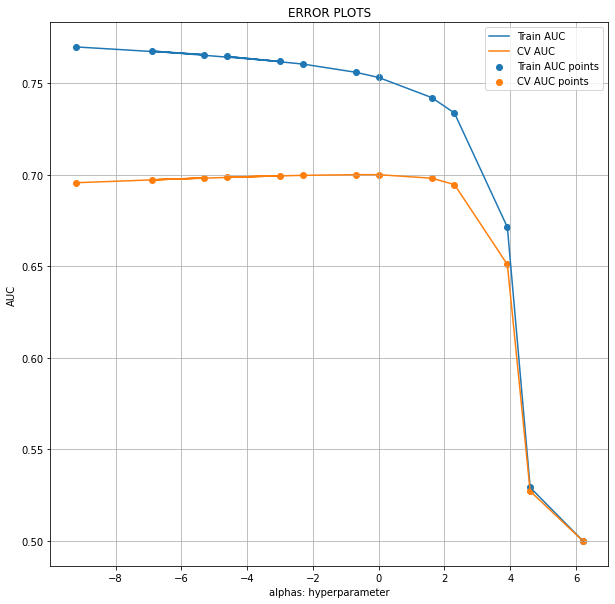

In [117]:
plt.figure(figsize=(10,10)) #https://stackoverflow.com/questions/48429156/how-to-resize-matplotlib-scatter-plot
plt.plot(alphas_log, train_auc, label='Train AUC')
plt.plot(alphas_log, cv_auc, label='CV AUC')

plt.scatter(alphas_log, train_auc, label='Train AUC points')
plt.scatter(alphas_log, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
#https://stackoverflow.com/questions/8209568/how-do-i-draw-a-grid-onto-a-plot-in-python
plt.rc('grid', linestyle="-", color='black') 
plt.grid(True)
plt.show()

In [118]:
print("alpha for the set-1 using batch method:","Alpha_value = '1' ","According to the Graph at 0 ") 

alpha for the set-1 using batch method: Alpha_value = '1'  According to the Graph at 0 


# use GridSearchCV method for Set-1(BOW)

In [119]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

prob_NB = MultinomialNB(class_prior=[0.5,0.5])
parameters = {'alpha':[0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100,500]}
Grid_search = GridSearchCV(prob_NB, parameters, cv= 10, scoring='roc_auc',return_train_score=True,verbose=2,n_jobs=1)
Grid_search.fit(X_tr_bow, y_train)

results = pd.DataFrame.from_dict(Grid_search.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha = results['param_alpha']

log_alphas = []
for alpha in alpha:
    log_alphas.append(math.log(alpha))

Fitting 10 folds for each of 13 candidates, totalling 130 fits
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END ........................................alpha=0.005; total time=   0.0s
[CV] END .....................................

[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ...................

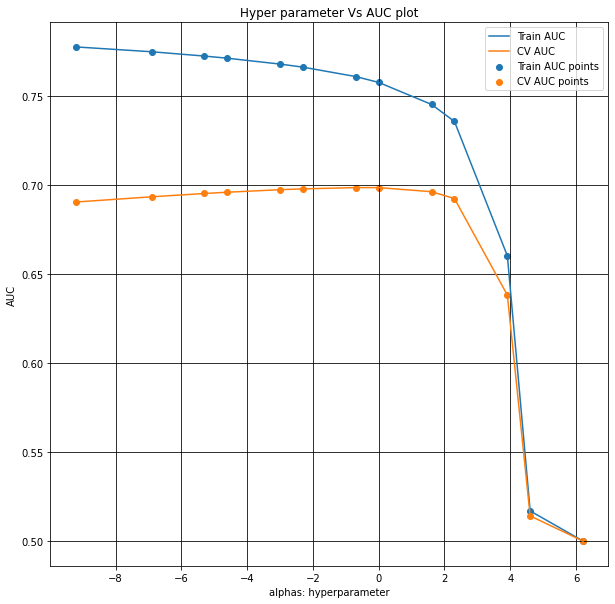

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.075336,0.006744,0.009042,0.003747,0.0001,{'alpha': 0.0001},0.702725,0.686393,0.692847,0.682345,...,0.779289,0.777934,0.775399,0.777152,0.776779,0.776747,0.777716,0.778016,0.777644,0.001119
2,0.072680,0.003998,0.008871,0.004367,0.001,{'alpha': 0.001},0.705410,0.689503,0.697689,0.687425,...,0.776484,0.775102,0.772705,0.774437,0.774149,0.774183,0.774930,0.775263,0.774922,0.001077
1,0.083902,0.020968,0.008833,0.002723,0.005,{'alpha': 0.005},0.707010,0.691483,0.700728,0.691044,...,0.773982,0.772585,0.770319,0.772029,0.771811,0.771898,0.772444,0.772806,0.772499,0.001038
4,0.082530,0.010975,0.008266,0.001445,0.01,{'alpha': 0.01},0.707618,0.692234,0.701936,0.692482,...,0.772736,0.771337,0.769136,0.770831,0.770651,0.770756,0.771206,0.771578,0.771294,0.001019
3,0.072440,0.003369,0.009106,0.005482,0.05,{'alpha': 0.05},0.708924,0.693751,0.704327,0.695713,...,0.769328,0.767921,0.765899,0.767550,0.767480,0.767627,0.767829,0.768225,0.767994,0.000971


In [120]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
plt.figure(figsize=(10,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.rc('grid', linestyle="-", color='black') 
plt.grid(True)
plt.show()

results.head()

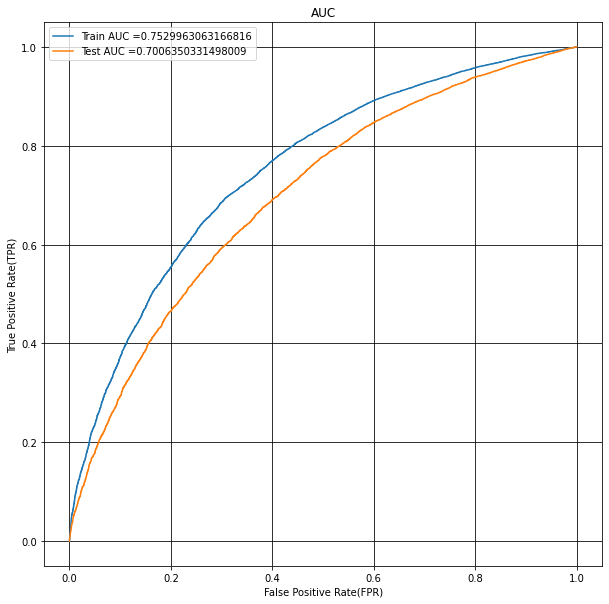

In [121]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
set1_bow = MultinomialNB(alpha = 1,class_prior=[0.5,0.5])
set1_bow.fit(X_tr_bow, y_train)

y_train_pred = batch_predict(set1_bow, X_tr_bow)    
y_test_pred = batch_predict(set1_bow, X_te_bow)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(10,10))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.rc('grid', linestyle="-", color='black') 
plt.grid(True)
plt.show()

# Summary

In [122]:
# for set- 1 (bow), batch wise method we get train and test AOC .73 and .69 Respectively

# Plot confusion matrix based on the best threshold value

In [123]:
# confusion matrix with predicted and original labels of test data points

In [124]:
from sklearn.metrics import confusion_matrix

# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [125]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.480891486698556 for threshold 0.408
Train confusion matrix
[[ 5146  2280]
 [12736 28879]]
Test confusion matrix
[[ 3338  2121]
 [ 9774 20819]]


Train confusion matrix


<AxesSubplot:>

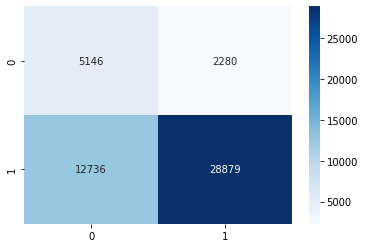

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Train confusion matrix")
sns.heatmap((confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))), annot=True,fmt="d",cmap='Blues')

Test confusion matrix


<AxesSubplot:>

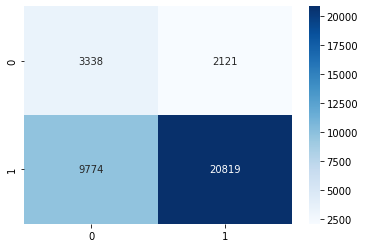

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Test confusion matrix")
sns.heatmap((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), annot=True,fmt="d",cmap='Blues')

# Summary

In [128]:
# As we see in the matrix train and test 

# ---> true  positive(28879 , 20819) have good number with respect to the False Negative(2280 , 2121)
#      in both train and test 

# -----------------------------------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------------------------------

# Set 2: categorical, numerical features + preprocessed_eassay (TFIDF)++preprocessed_title(TFIDF)

In [129]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf =  hstack((essay_tfidf_Xtrain, title_tfidf_Xtrain, resource_summary_tfidf_Xtrain, OHE_X_train_state, OHE_X_train_sub_cat, OHE_X_train_sub_sub_cat, OHE_X_tain_grade_catagory, OHE_X_tain_teacher_prefix, norm_X_train_price,norm_X_train_project_title_word, norm_X_train_project_essay_word, norm_X_train_previously_posted_projects, norm_X_train_quantity)).tocsr()
X_cv_tfidf =  hstack((essay_tfidf_Xcv, title_tfidf_Xcv, resource_summary_tfidf_Xcv, OHE_X_cv_state, OHE_X_cv_sub_cat, OHE_X_cv_sub_sub_cat, OHE_X_cv_grade_catagory, OHE_X_cv_teacher_prefix, norm_X_cv_price, norm_X_cv_project_title_word, norm_X_cv_project_essay_word, norm_X_cv_previously_posted_projects, norm_X_cv_quantity)).tocsr()
X_te_tfidf =  hstack((essay_tfidf_Xtest, title_tfidf_Xtest, resource_summary_tfidf_Xtest, OHE_X_test_state, OHE_X_test_sub_cat, OHE_X_test_sub_sub_cat, OHE_X_test_grade_catagory, OHE_X_test_teacher_prefix, norm_X_test_price, norm_X_test_project_title_word, norm_X_test_project_essay_word, norm_X_test_previously_posted_projects, norm_X_test_quantity)).tocsr()   

In [130]:
print(X_tr_tfidf.shape)
print(X_cv_tfidf.shape)
print(X_te_tfidf.shape)

(49041, 13932)
(24155, 13932)
(36052, 13932)


# use batch wise method for Set-2(TFIDF)

In [131]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [132]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
alphas = [0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100,500]
alphas_log=[]

for i in tqdm(alphas):
    log_alpha = math.log(i)
    alphas_log.append(log_alpha)
    prob_NB = MultinomialNB(alpha = i,class_prior=[0.5, 0.5]) # class_prior as per instructions
    prob_NB.fit(X_tr_tfidf, y_train)
    
    y_train_pred = batch_predict(prob_NB, X_tr_tfidf)    
    y_cv_pred = batch_predict(prob_NB, X_cv_tfidf)
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.93it/s]


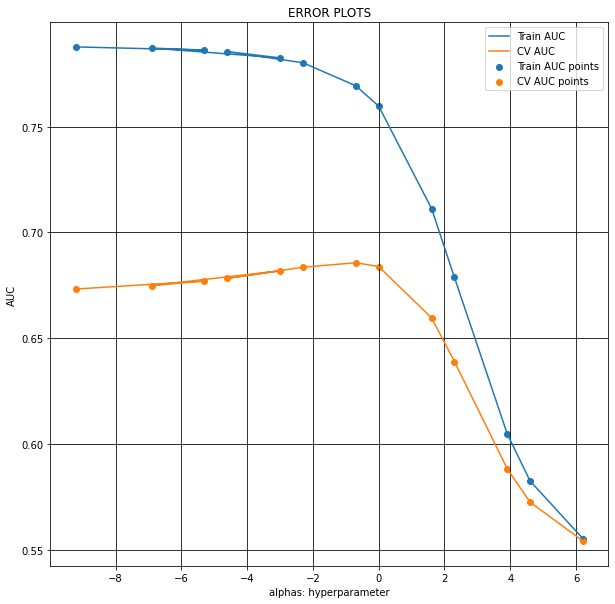

In [133]:
plt.figure(figsize=(10,10)) #https://stackoverflow.com/questions/48429156/how-to-resize-matplotlib-scatter-plot
plt.plot(alphas_log, train_auc, label='Train AUC')
plt.plot(alphas_log, cv_auc, label='CV AUC')

plt.scatter(alphas_log, train_auc, label='Train AUC points')
plt.scatter(alphas_log, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
#https://stackoverflow.com/questions/8209568/how-do-i-draw-a-grid-onto-a-plot-in-python
plt.rc('grid', linestyle="-", color='black') 
plt.grid(True)
plt.show()

In [134]:
print("alpha for the set-2 using batch method:","Alpha_value = '1' ","According to the Graph at 0 ")

alpha for the set-2 using batch method: Alpha_value = '1'  According to the Graph at 0 


# use GridSearchCV method for Set-2(TFIDF)

In [135]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

prob_NB = MultinomialNB(class_prior=[0.5,0.5])
parameters = {'alpha':[0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100,500]}
Grid_search = GridSearchCV(prob_NB, parameters, cv= 10, scoring='roc_auc',return_train_score=True,verbose=2,n_jobs=1)
Grid_search.fit(X_tr_tfidf, y_train)

results = pd.DataFrame.from_dict(Grid_search.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha = results['param_alpha']

log_alphas = []
for alpha in alpha:
    log_alphas.append(math.log(alpha))

Fitting 10 folds for each of 13 candidates, totalling 130 fits
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END ........................................alpha=0.005; total time=   0.0s
[CV] END .....................................

[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ...........................................alpha=50; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ..........................................alpha=100; total time=   0.0s
[CV] END ...................

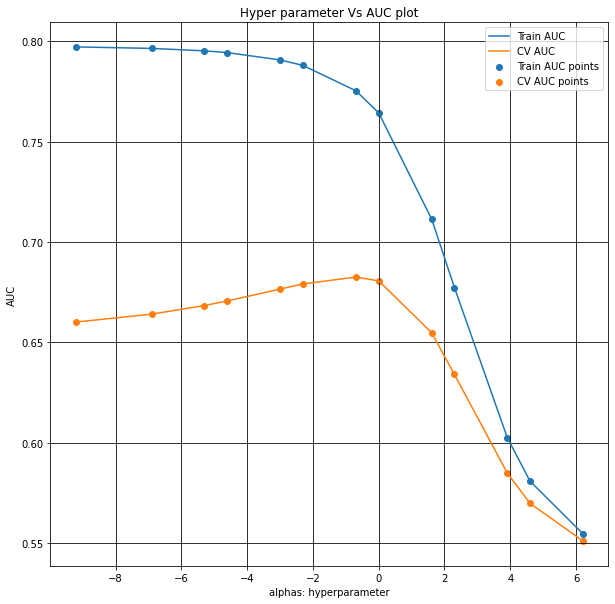

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.070915,0.002923,0.007077,0.000878,0.0001,{'alpha': 0.0001},0.668551,0.651586,0.649952,0.649110,...,0.797715,0.797986,0.796184,0.796953,0.796413,0.796336,0.796638,0.798097,0.797216,0.000789
2,0.069158,0.001458,0.006872,0.000312,0.001,{'alpha': 0.001},0.672140,0.657732,0.655830,0.653863,...,0.796959,0.797206,0.795432,0.796257,0.795708,0.795610,0.795891,0.797336,0.796475,0.000772
1,0.068845,0.001102,0.007122,0.000422,0.005,{'alpha': 0.005},0.676184,0.663360,0.662605,0.659616,...,0.795715,0.795938,0.794224,0.795084,0.794546,0.794420,0.794658,0.796092,0.795258,0.000745
4,0.070123,0.002841,0.006978,0.000632,0.01,{'alpha': 0.01},0.678410,0.665938,0.666156,0.662825,...,0.794810,0.795023,0.793354,0.794222,0.793699,0.793559,0.793761,0.795198,0.794378,0.000730
3,0.068174,0.001062,0.006822,0.000313,0.05,{'alpha': 0.05},0.684530,0.671884,0.675780,0.671944,...,0.791101,0.791261,0.789762,0.790606,0.790188,0.789990,0.790057,0.791491,0.790732,0.000675


In [136]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
plt.figure(figsize=(10,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

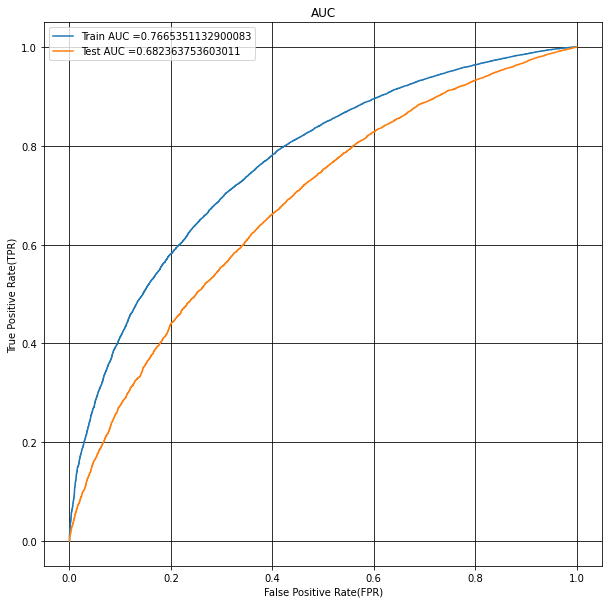

In [137]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
set2_tfidf = MultinomialNB(alpha=1,class_prior=[0.5,0.5])
set2_tfidf.fit(X_tr_bow, y_train)

y_train_pred = batch_predict(set2_tfidf, X_tr_tfidf)    
y_test_pred = batch_predict(set2_tfidf, X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(10,10))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.rc('grid', linestyle="-", color='black') 
plt.grid(True)
plt.show()

# Plot confusion matrix based on the best threshold value

In [138]:
# confusion matrix with predicted and original labels of test data points

In [139]:
from sklearn.metrics import confusion_matrix

# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [140]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4870680376227794 for threshold 0.304
Train confusion matrix
[[ 5133  2293]
 [12291 29324]]
Test confusion matrix
[[ 3135  2324]
 [ 9648 20945]]


Train confusion matrix


<AxesSubplot:>

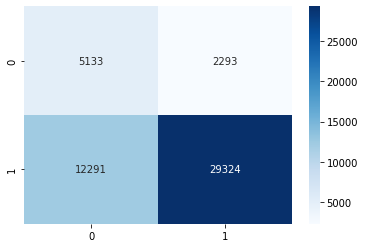

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Train confusion matrix")
sns.heatmap((confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))), annot=True,fmt="d",cmap='Blues')

Test confusion matrix


<AxesSubplot:>

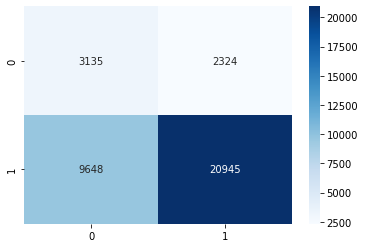

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Test confusion matrix")
sns.heatmap((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), annot=True,fmt="d",cmap='Blues')

# Summary

In [143]:
# As we see in the matrix train and test (set-2)(TFIDF)

# ---> true  positive(29324, 20945) have good number with respect to the False Negative(2293 , 2324)
#      in both train and test

In [144]:
# As we see in the matrix train and test 

# ---> true  positive(28879 , 20819) have good number with respect to the False Negative(2280 , 2121)
#      in both train and test 

In [145]:
# as we clearly see the there is the ---->
# increase in the number of Fasle Negative in the set-2  with respect to the set-1  
# decrease in the True positive in set -1 with respect to the set-2

In [146]:
# here we can see both model gives almost nearly results

# top 20 features from either from feature Set 1 or feature Set 2 using values of `feature_log_prob_ ` parameter of `MultinomialNB`

In [147]:
set1_bow = MultinomialNB(alpha =1 , class_prior=[0.5,0.5])
set1_bow.fit(X_tr_bow, y_train)

y_train_pred = batch_predict(set1_bow, X_tr_bow)    
y_test_pred = batch_predict(set1_bow, X_te_bow)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

In [148]:
# https://stackoverflow.com/questions/14131615/possible-to-append-multiple-lists-at-once-python
from itertools import chain
BOW_feature = (list(chain(eassy_feature,title_feature,summary_feature,teacher_prefix_feature,project_grade_category_feature,project_subject_subcategories_feature,project_subject_categories_feature,school_state_feature)))

In [149]:
# https://stackoverflow.com/questions/54988116/why-am-i-getting-almost-same-top-10-features-using-multinomial-naive-bayes-class

#For Positive class
positive_feature=[]
sorted_idx_1 = np.argsort(set1_bow.feature_log_prob_[1,:])[-20:]
for x in range(len(sorted_idx_1)):
    if len(BOW_feature)<=sorted_idx_1[x]:
        pass
    elif BOW_feature[sorted_idx_1[x]]:
        positive_feature.append(BOW_feature[sorted_idx_1[x]])
    else:
        pass
print(positive_feature)

['use', 'work', 'need', 'reading', 'nannan', 'many', 'students need', 'need', 'students', 'help', 'learn', 'not', 'classroom', 'learning', 'school', 'students']


In [152]:
# https://stackoverflow.com/questions/54988116/why-am-i-getting-almost-same-top-10-features-using-multinomial-naive-bayes-class

#For Negative class
Negative_feature=[]
sorted_idx_0 = np.argsort(set1_bow.feature_log_prob_[0,:])[-20:]
for x in range(len(sorted_idx_1)):
    if len(BOW_feature)<=sorted_idx_0[x]:
        pass
    elif BOW_feature[sorted_idx_0[x]]:
        Negative_feature.append(BOW_feature[sorted_idx_0[x]])
    else:
        pass
print(Negative_feature)     

['come', 'work', 'need', 'many', 'nannan', 'students need', 'need', 'students', 'help', 'learn', 'not', 'classroom', 'learning', 'school', 'students']


In [153]:
# summary--->  here we can see that there are some words which are common but some remain unique 

In [154]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
tabular_data = PrettyTable()
tabular_data.field_names = ["Vectorizer", "Model", "Alpha-Hyper Parameter", " Train-AUC", " Test_AUC"]

tabular_data.add_row(["BOW", "Naive Bayes", 1, 0.75, 0.70])
tabular_data.add_row(["TFIDF", "Naive Bayes", 1, 0.76, 0.68])

print(tabular_data)

+------------+-------------+-----------------------+------------+-----------+
| Vectorizer |    Model    | Alpha-Hyper Parameter |  Train-AUC |  Test_AUC |
+------------+-------------+-----------------------+------------+-----------+
|    BOW     | Naive Bayes |           1           |    0.75    |    0.7    |
|   TFIDF    | Naive Bayes |           1           |    0.76    |    0.68   |
+------------+-------------+-----------------------+------------+-----------+
